In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import umap
import time
import datetime
from deepAutoencoder import *
from betaVAE import *
from betaVSC import *
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
get_ipython().run_line_magic('matplotlib', 'inline')

import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(True)

In [2]:
device = torch.device("cpu")

**NOTE about training times: Model training done on hp elite book, intel core i7 8th gen**


## Data loading and helper functions
**Dataset**: PBMC3k  
**Datatype**: single cell RNA sequencing data (normalized count data).  
Features (columns) are genes, Samples (rows) repsresent individual cells.

In [19]:
# Pytorch Dataloader
class CellDataset(Dataset):
    """ Cell dataset."""

    # Initialize your data, load and remove unecessary first row
    def __init__(self):
        
        df = pd.read_csv('data/scPBMC.csv', delimiter=',')
        X = np.transpose(df.values)
        X = X[1:,:] #remove the first row
        X = X.astype(float)
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X)
        
        labels = pd.read_csv("data/pbmc_labels_int.csv")
        self.y_data = torch.from_numpy(labels.values[:,1:])

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len
    
################################################################
################################################################
# Perform t-SNE
def tSNE(codes, labels, n):
    codes = np.vstack(codes)
    if codes.shape[1] > 2:
        print('running tsne to the latent space ... ')
        codes = TSNE(n_components = n, perplexity = 40).fit_transform(codes)
        
    labels = np.vstack(labels)
    labels = [item for sublist in labels for item in sublist]
    if n != 2:
        df = pd.DataFrame(dict(x=codes[:, 0], y=codes[:, 1], z=codes[:, 2], label=labels))
    else:
        df = pd.DataFrame(dict(x=codes[:, 0], y=codes[:, 1], label=labels))
    return df

################################################################
################################################################
# Helper function for plotting tsne embedding
def plot2Dtsne(df, title):
    groups = df.groupby('label')
    plt.rcParams["figure.figsize"] = [10,10]
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, label=dictlabels[name],)
    ax.legend(loc="upper right")
    ax.set_title(title)
    plt.show()
    
################################################################
################################################################
#Plotly #D scatter plot for t-SNE
def plot3Dtsne(df):

    grouped = df.groupby("label")
    traces_list = []
    for idx, val in enumerate(grouped):
        dff = val[1]
        x, y, z = list(dff.x), list(dff.y), list(dff.z)
        trace = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            name=dictlabels[val[0]],
            mode='markers',
            marker=dict(
                size=2,
                color=val[0], 
                opacity=0.8
            )
        )
        traces_list.append(trace)

    plot = go.Figure(traces_list)
    iplot(plot)

################################################################
################################################################
# Load data
dataset = CellDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=240,
                          shuffle=True)

test_loader = DataLoader(dataset=dataset,
                         batch_size=5,
                         shuffle=False)

################################################################
################################################################
# CLuster labels produced by Seurat clustering are in file "pbmc_labels_str.csv"
# dictlabels variable is used for tsne-plots
labels_str = pd.read_csv("data/pbmc_labels_str.csv")
valuelbl = [5, 7, 3, 0, 4, 1, 6, 8, 2]
dictlabels = dict(zip(valuelbl, list(set(labels_str.labels))))



## Deep Autoencoder

In [4]:
# Create autoencoder instance
autoencoder = Autoencoder(latent_size=6)
autoencoder.to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

## TRAINING DEEP AUTOENCODER

In [5]:
# TRAIN FOR 200 EPOCHS
print_every=75
t0=time.time()
for epoch in range(200):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs = inputs.to(device)
        optimizer.zero_grad()
        x_hat = autoencoder(inputs.float())
        loss = MSE_loss(x_hat, inputs.float())
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % print_every == 0:    # print every 15 mini-batches
            print('loss: ', loss.item(), 'epoch: ', epoch)
t1=time.time()

print('Finished Training')

loss:  989484.75 epoch:  0
loss:  879270.75 epoch:  1
loss:  661829.875 epoch:  2
loss:  520706.0625 epoch:  3
loss:  480010.25 epoch:  4
loss:  472343.78125 epoch:  5
loss:  464894.4375 epoch:  6
loss:  469461.8125 epoch:  7
loss:  468209.90625 epoch:  8
loss:  462404.65625 epoch:  9
loss:  463772.90625 epoch:  10
loss:  460715.09375 epoch:  11
loss:  471831.0625 epoch:  12
loss:  468957.6875 epoch:  13
loss:  464332.15625 epoch:  14
loss:  465820.375 epoch:  15
loss:  464128.28125 epoch:  16
loss:  462870.71875 epoch:  17
loss:  475093.65625 epoch:  18
loss:  467199.09375 epoch:  19
loss:  464701.4375 epoch:  20
loss:  465593.9375 epoch:  21
loss:  450998.34375 epoch:  22
loss:  446493.875 epoch:  23
loss:  446039.4375 epoch:  24
loss:  449929.65625 epoch:  25
loss:  449661.8125 epoch:  26
loss:  448721.75 epoch:  27
loss:  449155.84375 epoch:  28
loss:  435418.09375 epoch:  29
loss:  439992.8125 epoch:  30
loss:  441504.6875 epoch:  31
loss:  446119.71875 epoch:  32
loss:  444161.12

In [15]:
# PLOT THE LATENT DIMENSION
print("Model training time:", datetime.timedelta(seconds=round(t1-t0,0)))
codes, labels = [], []

for i in range(len(train_loader.dataset)):
    z = autoencoder.encode(train_loader.dataset.x_data[i].float())
    label = train_loader.dataset.y_data[i]
    labels.append(label.data.numpy())
    codes.append(z.data.numpy())

df2d = tSNE(codes, labels, 2)
df3d = tSNE(codes, labels, 3)

Model training time: 0:04:02
running tsne to the latent space ... 
running tsne to the latent space ... 


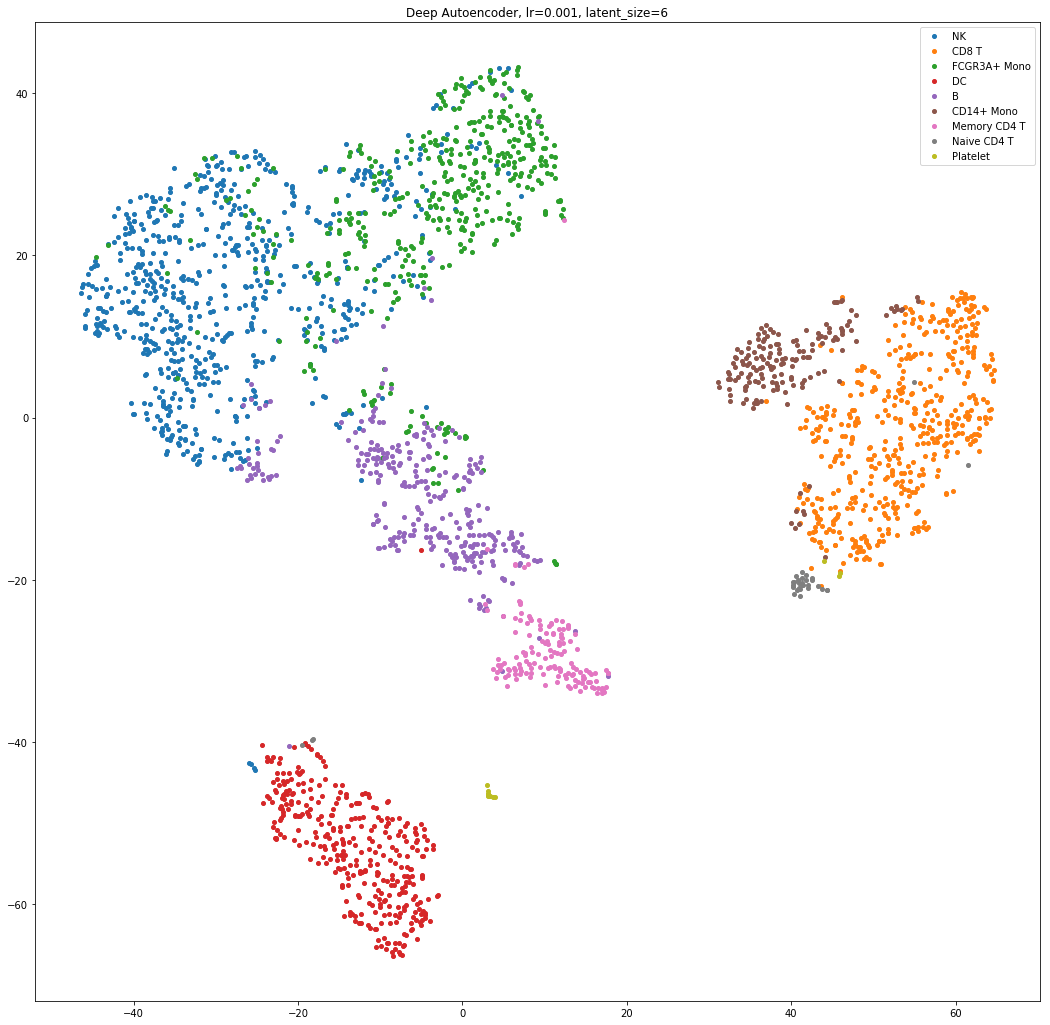

In [16]:
plot2Dtsne(df2d, 'Deep Autoencoder, lr=0.001, latent_size=6')
plot3Dtsne(df3d)

## $\beta$-VAE

In [17]:
betaVae1 = betaVAE(latent_size=6)
betaVae1.to(device)
optimizer = torch.optim.Adam(betaVae1.parameters(), lr=0.001)

In [18]:
# Beta value set to 1
t0=time.time()
train_betaVAE(beta=2.0, betaVae=betaVae1, train_loader=train_loader, device=device, optimizer=optimizer)
t1=time.time()

Beta value:  2.0
loss:  977299.5625 epoch:  0
loss:  611096.4375 epoch:  1
loss:  510566.6875 epoch:  2
loss:  474082.875 epoch:  3
loss:  474591.1875 epoch:  4
loss:  473358.25 epoch:  5
loss:  473665.8125 epoch:  6
loss:  452843.9375 epoch:  7
loss:  453485.625 epoch:  8
loss:  444097.625 epoch:  9
loss:  453431.09375 epoch:  10
loss:  444639.125 epoch:  11
loss:  455268.5 epoch:  12
loss:  443379.3125 epoch:  13
loss:  441351.125 epoch:  14
loss:  443497.78125 epoch:  15
loss:  436746.84375 epoch:  16
loss:  436609.46875 epoch:  17
loss:  440028.15625 epoch:  18
loss:  436342.28125 epoch:  19
loss:  430411.4375 epoch:  20
loss:  437782.15625 epoch:  21
loss:  434297.21875 epoch:  22
loss:  432743.75 epoch:  23
loss:  433528.78125 epoch:  24
loss:  431597.15625 epoch:  25
loss:  438058.78125 epoch:  26
loss:  436967.3125 epoch:  27
loss:  429694.3125 epoch:  28
loss:  432228.9375 epoch:  29
loss:  431275.8125 epoch:  30
loss:  429009.5625 epoch:  31
loss:  432597.71875 epoch:  32
los

In [20]:
codes, labels = [], []

for i in range(len(train_loader.dataset)):
    mu, log_var = betaVae1.encode(train_loader.dataset.x_data[i].float())
    sample = betaVae1.reparameterize(mu, log_var)
    label = train_loader.dataset.y_data[i]
    labels.append(label.data.numpy())
    codes.append(sample.data.numpy())

    
codes = np.vstack(codes)
print("Model training time:", datetime.timedelta(seconds=round(t1-t0,0)))
df2d = tSNE(codes, labels, 2)
df3d = tSNE(codes, labels, 3)

Model training time: 0:20:31
running tsne to the latent space ... 
running tsne to the latent space ... 


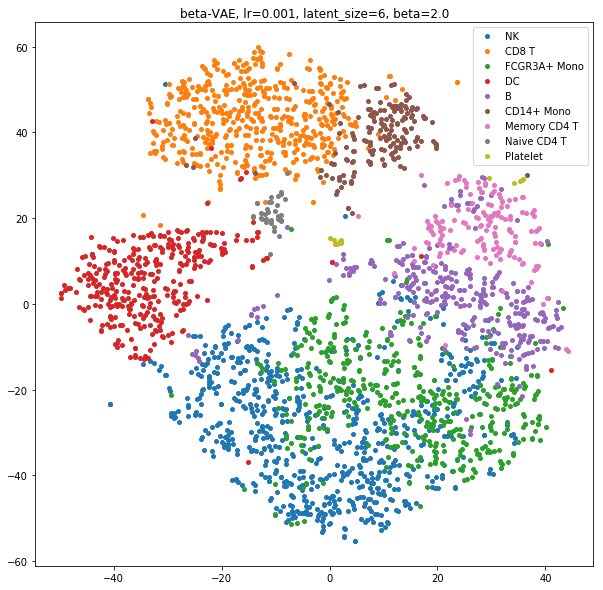

In [22]:
plot2Dtsne(df2d, 'beta-VAE, lr=0.001, latent_size=6, beta=2.0')
plot3Dtsne(df3d)

## $\beta$-VSC

In [10]:
betaVSC = betaVSC(latent_size=6)
betaVSC.to(device)
optimizer = torch.optim.Adam(betaVSC.parameters(), lr=0.001)

In [11]:
t0=time.time()
train_VSC(beta=2.0, VSC=betaVSC, train_loader=train_loader, device=device, optimizer=optimizer)
t1=time.time()

loss:  976811.25 epoch:  0
loss:  575938.3125 epoch:  1
loss:  489425.78125 epoch:  2
loss:  473656.90625 epoch:  3
loss:  472809.0 epoch:  4
loss:  471874.0625 epoch:  5
loss:  468292.0 epoch:  6
loss:  473776.40625 epoch:  7
loss:  471228.21875 epoch:  8
loss:  465130.6875 epoch:  9
loss:  470600.03125 epoch:  10
loss:  469881.125 epoch:  11
loss:  467701.90625 epoch:  12
loss:  466766.875 epoch:  13
loss:  452798.75 epoch:  14
loss:  448413.40625 epoch:  15
loss:  447547.84375 epoch:  16
loss:  448224.375 epoch:  17
loss:  439205.5 epoch:  18
loss:  435708.84375 epoch:  19
loss:  442391.90625 epoch:  20
loss:  433826.6875 epoch:  21
loss:  435401.1875 epoch:  22
loss:  436795.4375 epoch:  23
loss:  436240.96875 epoch:  24
loss:  431611.1875 epoch:  25
loss:  435397.28125 epoch:  26
loss:  434384.34375 epoch:  27
loss:  431814.15625 epoch:  28
loss:  433577.3125 epoch:  29
loss:  428068.125 epoch:  30
loss:  434053.40625 epoch:  31
loss:  431234.625 epoch:  32
loss:  432363.84375 epo

Model training time: 0:25:22
plotting latent space with tsne ... 


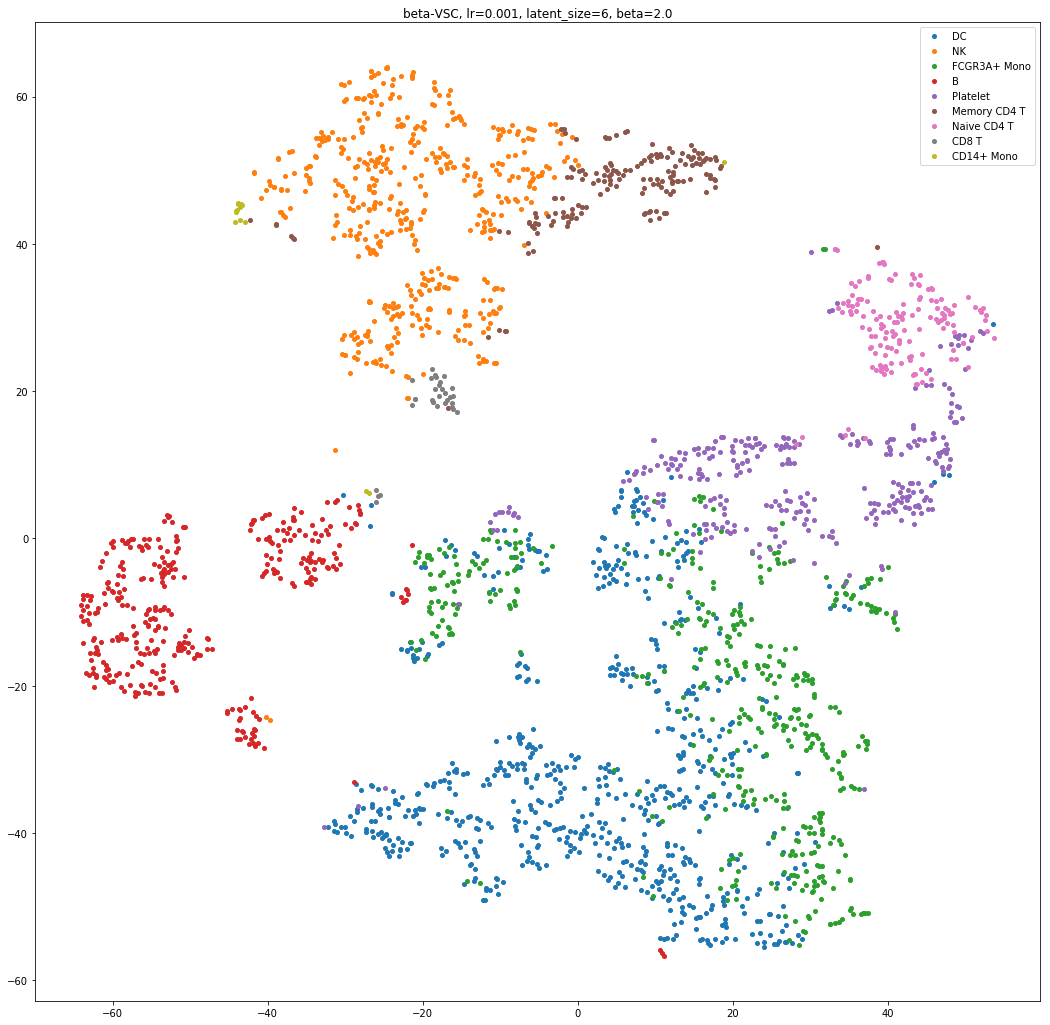

In [12]:
# TSNE-PLOT THE LATENT DIMENSION 
codes, labels = [], []

for i in range(len(train_loader.dataset)):
    mu, log_var, log_spike = betaVSC.encode(train_loader.dataset.x_data[i].float())
    sample = betaVSC.reparameterize(mu, log_var, log_spike)
    label = train_loader.dataset.y_data[i]
    labels.append(label.data.numpy())
    codes.append(mu.data.numpy())


print("Model training time:", datetime.timedelta(seconds=round(t1-t0,0)))
plot_tsne(codes, labels, title='beta-VSC, lr=0.001, latent_size=6, beta=2.0')
plot3Dtsne(codes, labels, title='beta-VSC, lr=0.001, latent_size=6, beta=2.0')